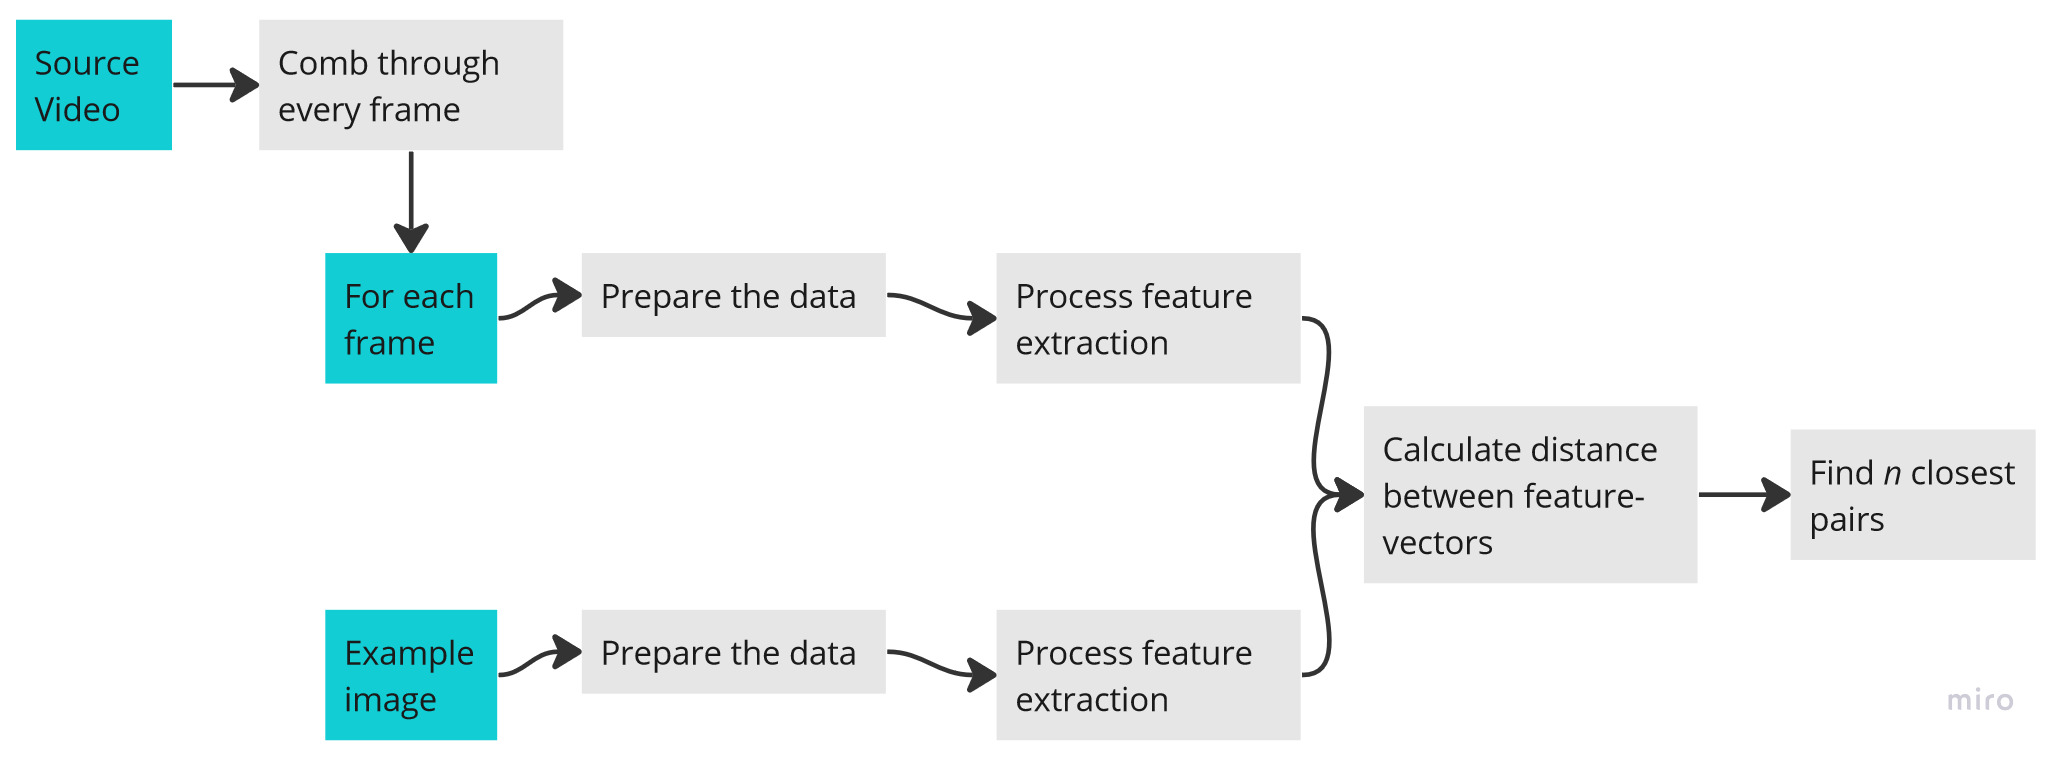

* **[Complete before *dd-mm-yyyy*]** Task name

**TODO**

* **[23-11-2023]** tratamento (estatístico(?)) dos resultados da crowd
* **[30-11-2023]** apresentar imagens pós-validação da crowd
* **[21-12-2023]** escolher dataset final + test images

**DOING**

* **[16-11-2023]** criar qualifications/criar filtros para crowd (review policies(?)/ScoreMyKnownAnswer(?))
* **[07-12-2023]** get the worker's ID to pay bonus
* **[07-12-2023]** aceitar HITS/enviar bonus (SendBonus(?)/dependendo do output de ScoreMyKnownAnswer(?))

**DONE**

* **[21-09-2023]** implementar algoritmo para medir semelhança entre imagens
* **[05-10-2023]** ler credenciais do ficheiro
* **[05-10-2023]** enviar resultados para bucket S3
* **[05-10-2023]** adaptar HTML para a task
* **[12-10-2023]** criar HITS com imagens no bucket
* **[26-10-2023]** receber resultados da crowd
* **[09-11-2023]** randomizar query no mturk (sem estragar os batches...)

In [1]:
#handle AWS
!pip install boto3
!pip install xmltodict

import boto3
import xmltodict
import json
from google.colab import files
import re

files.upload()
with open("aws.json") as json_file:
    credentials = json.load(json_file)

aws_key=credentials['aws_key']
aws_secret_key=credentials['aws_secret_key']


                                                                                                #for parsing through the (human readable) results
def find_workers_answers(answers_feed):                                                         #answer_to_known = [0], #answer_to_batch1 = [1]
  free_text = json.loads(answers_feed['QuestionFormAnswers']['Answer']['FreeText'])[0]
  known_image_batch = free_text['KnownImageBatch']
  known_true_images = [image for image, value in known_image_batch.items() if value]
  image_batch_1 = free_text['ImageBatch1']
  batch1_true_images = [image for image, value in image_batch_1.items() if value]
  return (int)(known_true_images[-1][-1]), (int)(batch1_true_images[-1][-1])                    #get ints from the text entries


def get_known_from_current_batch(data_feed, batch_number):                                      #known_number = [0], known_position = [1]
    for entry in data_feed:
        if entry['batch'] == batch_number:
            known_image_text = entry['Known Image']
            positions = [int(match.group()) for match in re.finditer(r'\d+', known_image_text)] #regex to find ints in the text
            return tuple(positions) if positions else 0


def create_batches_in_s3_bucket(image_path, bucket_name, directory, batch_name):
  k = number_of_matches + 1 #batch size
  j = 0                     #3 iterators
  i = 1
  m = 0
  result_images = []
  image_batch = []
  session = boto3.Session(
      aws_access_key_id = aws_key,
      aws_secret_access_key = aws_secret_key,
  )
  s3 = session.resource('s3')
  for image_dir in sorted(os.listdir(directory)):
    key_name=f"{batch_name}_{i}_{j}.jpeg"
    s3.meta.client.upload_file(Filename=directory + "/" + image_dir , Bucket=bucket_name, Key=key_name)
    image_batch.append(aws_image_path + key_name)
    j+=1
    if j == k:
      result_images.append(image_batch.copy())
      image_batch.clear()
      j = 0
      i+=1
  return result_images

#all HIT details here
base_payment = '0.05'
bonus_payment = '0.15'
number_of_workers_answering = 10
task_duration_in_seconds = 60*10
time_to_respond_in_seconds = 60*3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 82.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 12.1 MB/s eta 0:00:00


Saving aws.json to aws.json


In [2]:
#handle Drive
import cv2
import os
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np
import pickle
import shutil
import math
from matplotlib import pyplot as plt
from matplotlib import image as mpimg

from google.colab import drive
drive.mount('/content/drive')


#convert cardinals to ordinals
list_of_suffixes = {1: 'st', 2: 'nd', 3: 'rd'}
def ordinal(num):
    if 10 <= num % 100 <= 20:                         #mind exceptions 10-20
        suffix = 'th'
    else:
        suffix = list_of_suffixes.get(num % 10, 'th') #th by default
    return str(num) + suffix

Mounted at /content/drive


In [3]:
#define the necessary paths here
video_directory = '/content/drive/MyDrive/Colab Notebooks/CrowdSourcing/data/sample.mp4'
vframes_directory = '/content/drive/MyDrive/Colab Notebooks/CrowdSourcing/data/vframes'
testimages_directory = '/content/drive/MyDrive/Colab Notebooks/CrowdSourcing/data/testimages'
results_directory = '/content/drive/MyDrive/Colab Notebooks/CrowdSourcing/data/results'
knownanswers_directory = '/content/drive/MyDrive/Colab Notebooks/CrowdSourcing/data/knownanswers'
logs_directory = '/content/drive/MyDrive/Colab Notebooks/CrowdSourcing/data/logs.txt'
pickle_directory = '/content/drive/MyDrive/Colab Notebooks/CrowdSourcing/data/pickled_features_dict.pkl'
html_directory = '/content/drive/MyDrive/Colab Notebooks/CrowdSourcing/SentimentQuestion.html' #working page

#define number of matches here
number_of_matches = 3

In [ ]:
#extract frames from sample video

logs = open(logs_directory, 'w')

vidcap = cv2.VideoCapture(video_directory)
success, img = vidcap.read()
count = 0
while success:
  if count%10 == 0: # every 10th frame
    cv2.imwrite(vframes_directory + "/frame%d.jpg" % count, img)     # save frame as JPEG file
    success, img = vidcap.read()
    logs.write(f"Frame {count} processed.\n")
  else:
    success, img = vidcap.read()
  count += 1

In [ ]:
#extract features from each video-frame to dict

logs = open(logs_directory, 'w')
features_dict = dict()

#import model without classifier
model = VGG16(weights='imagenet', include_top=False)

#loop files in directory
for filename in os.listdir(vframes_directory):
    f = os.path.join(vframes_directory, filename)
    test_img = image.load_img(f, target_size=(224, 224))
    x = image.img_to_array(test_img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    test_features = model.predict(x)
    logs.write(f"Image {filename} processed\n")
    features_dict[filename] = test_features

1/1 [==============================] - 1s 991ms/step


In [ ]:
#save features to file

with open(pickle_directory, 'wb') as fp:
    pickle.dump(features_dict, fp)
    print('Dict saved to file.')

Dict saved to file.


In [ ]:
#load features from file

with open(pickle_directory, 'rb') as fp:
    features_dict = pickle.load(fp)
    print('Dict loaded from file.')

Dict loaded from file.


In [ ]:
#test every image on diretory

#import model without classifier
model = VGG16(weights='imagenet', include_top=False)

imgDict = dict()
image_count = 0

#loop files in directory
for filename in os.listdir(testimages_directory):
    image_count+=1
    target_img_path = os.path.join(testimages_directory, filename)

    #prepare image to be fed to model
    target_img = image.load_img(target_img_path, target_size=(224, 224))
    x = image.img_to_array(target_img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    #print target_img
    plt.title("Target image")
    first_image = mpimg.imread(target_img_path)
    plt.imshow(first_image)
    plt.show()

    #extract features-vector
    target_features = model.predict(x)

    #inelegant but works every time
    distance = 1000000

    #save to folder for analysis
    shutil.copy(target_img_path, results_directory + f"/frame{image_count}.jpeg")

    #clean data struct for current attempt
    imgDict.clear()

    #take features from dict, compare to target, write distance to imgDict
    for key in features_dict.keys():
        test_features = features_dict[key]
        temp = target_features - test_features
        new_distance = np.linalg.norm(temp)
        imgDict[key] = new_distance

    #report results up to n = number_of_matches
    for i in range(number_of_matches):
        best_img = min(imgDict, key=imgDict.get)

        ordinal_label = ordinal(i+1)

        #print best_img
        plt.title(f"{ordinal_label} match: {best_img}")

        best_img_path = os.path.join(vframes_directory, best_img)
        final_image = mpimg.imread(best_img_path)
        plt.imshow(final_image)
        plt.show()

        #save results to folder for analysis
        shutil.copy(best_img_path, results_directory + f"/frame{image_count}_{ordinal_label}_match_at_video_{best_img[:-4]}_and_distance_{imgDict[best_img]}.jpeg")

        #after reporting result i, eliminate from dict to go to i+1
        del imgDict[best_img]

Output hidden; open in https://colab.research.google.com to view.

In [4]:
#create batches in s3 bucket
aws_image_path = "https://imgsimilarity.s3.eu-north-1.amazonaws.com/"
my_bucket = 'imgsimilarity'

result_images = create_batches_in_s3_bucket(aws_image_path, my_bucket, results_directory, "batch")
print(result_images)

known_images = create_batches_in_s3_bucket(aws_image_path, my_bucket, knownanswers_directory, "known_batch")
print(known_images)

[['https://imgsimilarity.s3.eu-north-1.amazonaws.com/batch_1_0.jpeg', 'https://imgsimilarity.s3.eu-north-1.amazonaws.com/batch_1_1.jpeg', 'https://imgsimilarity.s3.eu-north-1.amazonaws.com/batch_1_2.jpeg', 'https://imgsimilarity.s3.eu-north-1.amazonaws.com/batch_1_3.jpeg'], ['https://imgsimilarity.s3.eu-north-1.amazonaws.com/batch_2_0.jpeg', 'https://imgsimilarity.s3.eu-north-1.amazonaws.com/batch_2_1.jpeg', 'https://imgsimilarity.s3.eu-north-1.amazonaws.com/batch_2_2.jpeg', 'https://imgsimilarity.s3.eu-north-1.amazonaws.com/batch_2_3.jpeg'], ['https://imgsimilarity.s3.eu-north-1.amazonaws.com/batch_3_0.jpeg', 'https://imgsimilarity.s3.eu-north-1.amazonaws.com/batch_3_1.jpeg', 'https://imgsimilarity.s3.eu-north-1.amazonaws.com/batch_3_2.jpeg', 'https://imgsimilarity.s3.eu-north-1.amazonaws.com/batch_3_3.jpeg'], ['https://imgsimilarity.s3.eu-north-1.amazonaws.com/batch_4_0.jpeg', 'https://imgsimilarity.s3.eu-north-1.amazonaws.com/batch_4_1.jpeg', 'https://imgsimilarity.s3.eu-north-1.ama

In [5]:
#prepare HITs

create_hits_in_production = False # !!
environments = {
        "production": {
            "endpoint": "https://mturk-requester.us-east-1.amazonaws.com",
            "preview": "https://www.mturk.com/mturk/preview"
        },
        "sandbox": {
            "endpoint": "https://mturk-requester-sandbox.us-east-1.amazonaws.com",
            "preview": "https://workersandbox.mturk.com/mturk/preview"
        },
}
mturk_environment = environments["production"] if create_hits_in_production else environments["sandbox"]

client = boto3.client(
    service_name='mturk',
    region_name='us-east-1',
    endpoint_url=mturk_environment['endpoint'],
    aws_access_key_id = aws_key,
    aws_secret_access_key = aws_secret_key
)

html_layout = open(html_directory, 'r').read()
QUESTION_XML = """<HTMLQuestion xmlns="http://mechanicalturk.amazonaws.com/AWSMechanicalTurkDataSchemas/2011-11-11/HTMLQuestion.xsd">
        <HTMLContent><![CDATA[{}]]></HTMLContent>
        <FrameHeight>650</FrameHeight>
        </HTMLQuestion>"""
question_xml = QUESTION_XML.format(html_layout)

TaskAttributes = {
    'MaxAssignments': number_of_workers_answering ,                   #how many workers will answer each HIT
    'LifetimeInSeconds': task_duration_in_seconds,                    #how long the task will be available on MTurk (10 min)
    'AssignmentDurationInSeconds': time_to_respond_in_seconds,        #how long Workers have to complete each item (3 min)
    'Reward': base_payment,                                           #the reward for each response
    'Title': 'Find similar images',
    'Keywords': 'similarity, vision',
    'Description': f'Select which test image is closest to the target image. If you answer the validation question correctly, a {bonus_payment}$ bonus will be paid'
}

In [6]:
#publish HITs
import random

results = []
hit_type_id = ''
number_of_test_images = (int)(len(os.listdir(results_directory))/(number_of_matches+1))         #using 4 test images for now (frame_1->4)
number_of_known_answers = (int)(len(os.listdir(knownanswers_directory))/(number_of_matches+1))  #using 4 known answers for now (known_1->4)
random_known_answer = 0
question_order = [1, 2, 3]                                                                      #to randomize the location of the AI's 1st_match
known_order = [1, 2, 3]                                                                         #to randomize the location of the correct image in the known answer batch
j = 1
register_question_order = []

for i in range(number_of_test_images):
    random.shuffle(question_order)
    random.shuffle(known_order)
    random_known_answer = random.randint(0, number_of_known_answers-1)                          #to pick a random known answer batch
    response = client.create_hit(
        **TaskAttributes,
        Question=question_xml.replace('${target_image_url}', result_images[i][0]).replace('${item1_image_url}', result_images[i][question_order[0]]).replace('${item2_image_url}', result_images[i][question_order[1]]).replace('${item3_image_url}',
                                      result_images[i][question_order[2]]).replace('${known_target_image_url}', known_images[random_known_answer][0]).replace('${known_item1_image_url}', known_images[random_known_answer][known_order[0]]).replace('${known_item2_image_url}',
                                      known_images[random_known_answer][known_order[1]]).replace('${known_item3_image_url}', known_images[random_known_answer][known_order[2]])
    )
    hit_type_id = response['HIT']['HITTypeId']
    results.append({
        'batch': j,
        'hit_id': response['HIT']['HITId']
    })
    #
    register_question_order.append({                                                            #actually noting down the position of the images here
        'batch': j,
        'Image 1': f"frame{j}_{ordinal(question_order[0])}_match",
        'Image 2': f"frame{j}_{ordinal(question_order[1])}_match",
        'Image 3': f"frame{j}_{ordinal(question_order[2])}_match",
        'Known Image': f"known_{random_known_answer+1} at position {known_order.index(1)+1}",
    })
    #
    j+=1

print("HITs available at:")
print(mturk_environment['preview'] + "?groupId={}".format(hit_type_id))

print(json.dumps(register_question_order,indent=2))


HITs available at:
https://workersandbox.mturk.com/mturk/preview?groupId=3PEM1NC0NUZ2A1B1AW01YN3A35RIHA
[
  {
    "batch": 1,
    "Image 1": "frame1_1st_match",
    "Image 2": "frame1_2nd_match",
    "Image 3": "frame1_3rd_match",
    "Known Image": "known_2 at position 1"
  },
  {
    "batch": 2,
    "Image 1": "frame2_3rd_match",
    "Image 2": "frame2_1st_match",
    "Image 3": "frame2_2nd_match",
    "Known Image": "known_1 at position 2"
  },
  {
    "batch": 3,
    "Image 1": "frame3_2nd_match",
    "Image 2": "frame3_3rd_match",
    "Image 3": "frame3_1st_match",
    "Known Image": "known_1 at position 3"
  },
  {
    "batch": 4,
    "Image 1": "frame4_1st_match",
    "Image 2": "frame4_3rd_match",
    "Image 3": "frame4_2nd_match",
    "Known Image": "known_3 at position 1"
  }
]


In [24]:
#retrieve results

parsed_results = {}
known_answer_results = {}

for item in results:

    #get the status of the HIT
    hit = client.get_hit(HITId=item['hit_id'])
    item['status'] = hit['HIT']['HITStatus']

    #get a list of the Assignments that have been submitted by Workers
    assignmentsList = client.list_assignments_for_hit(
        HITId=item['hit_id'],
        AssignmentStatuses=['Submitted', 'Approved'],
        MaxResults=10
    )

    assignments = assignmentsList['Assignments']
    item['assignments_submitted_count'] = len(assignments)

    answers = []
    for assignment in assignments:

        #retreive the attributes for each assignment
        worker_id = assignment['WorkerId']
        assignment_id = assignment['AssignmentId']

        #retrieve the value submitted by the Worker from the XML
        answer_dict = xmltodict.parse(assignment['Answer'])
        answer = answer_dict['QuestionFormAnswers']['Answer']['FreeText']
        answers.append(str(answer))
        item['answers'] = answers

        #checking if the worker passed the known answer (and paying the bonus)  TODO : fix bonus going out multiple times
        current_batch = item['batch']
        correct_known_ans = get_known_from_current_batch(register_question_order, current_batch)[1]
        worker_known_ans = find_workers_answers(answer_dict)[0]
        worker_batch_ans = find_workers_answers(answer_dict)[1]
        known_answer_results[f"current batch: {current_batch}, correct known answer = {correct_known_ans}, worker_id: {worker_id}"] = f"Image {worker_known_ans}"

        if(worker_known_ans == correct_known_ans):                              #bonus paid, worker votes on the final result
          bonus_response = client.send_bonus(
              WorkerId=worker_id,
              BonusAmount=bonus_payment,
              AssignmentId=assignment_id,
              Reason=f'You passed the validation question, thank you for your hard work. A {bonus_payment}$ bonus will be delivered.'#,
              #UniqueRequestToken='string'                                      TODO : implement token to reattempt the connection
          )
          parsed_results[f"current batch: {current_batch}, worker_id: {worker_id}"] = f"Image {worker_batch_ans}"

        else:                                                                   #bonus not paid, worker does not vote on the final result
          no_bonus_response = client.notify_workers(
              Subject=TaskAttributes['Title'],
              MessageText=f'You failed the validation question, the {bonus_payment}$ bonus will not be delivered. Nevertheless, we thank you for your hard work.',
              WorkerIds=[worker_id]
          )

        #approve the submitted assignment
        if assignment['AssignmentStatus'] == 'Submitted':
            client.approve_assignment(
                AssignmentId=assignment_id,
                OverrideRejection=False
            )


#print(json.dumps(results,indent=2))              #raw results
#print(json.dumps(known_answer_results,indent=2)) #workers answers to known_answer
print(json.dumps(parsed_results, indent=2))       #results validated via our gold standard

{
  "current batch: 1, worker_id: A174PJIIHV2J2V": "Image 1",
  "current batch: 1, worker_id: A235Y5O26VHSAY": "Image 1",
  "current batch: 2, worker_id: A235Y5O26VHSAY": "Image 3",
  "current batch: 3, worker_id: A174PJIIHV2J2V": "Image 1",
  "current batch: 3, worker_id: A235Y5O26VHSAY": "Image 3"
}


In [ ]:
#foreach image batch
  #find the majority vote
  #translate that to an actual image directory
  #present the image

In [11]:
#kill all HITs

from datetime import datetime

#get the MTurk client
mturk=boto3.client('mturk',
        aws_access_key_id = aws_key,
        aws_secret_access_key = aws_secret_key,
        region_name='us-east-1',
        endpoint_url="https://mturk-requester-sandbox.us-east-1.amazonaws.com",
    )

#delete HITs
for item in mturk.list_hits()['HITs']:
    hit_id=item['HITId']
    print('HITId:', hit_id)

    #get HIT status
    status=mturk.get_hit(HITId=hit_id)['HIT']['HITStatus']
    print('HITStatus:', status)

    #if HIT is active, set it to expire immediately
    if status=='Assignable':
        response = mturk.update_expiration_for_hit(
            HITId=hit_id,
            ExpireAt=datetime(2015, 1, 1)
        )

    #delete the HIT
    try:
        mturk.delete_hit(HITId=hit_id)
    except:
        print('Not deleted')
    else:
        print('Deleted')

HITId: 31GN6YMHM6CPBD03GFBZICQUO6VWSR
HITStatus: Reviewable
Deleted
HITId: 3UY4PIS8R85ZUZSVBV5SQSQU5UEN17
HITStatus: Reviewable
Deleted
HITId: 34O39PNDLNSLMV2F6ZFY5O8DS3URBI
HITStatus: Reviewable
Deleted
HITId: 3PEG1BH7BVBZZRPKGF614CMZXB0KBI
HITStatus: Reviewable
Deleted
HITId: 3IWA71V4UZ0ZDF7WJ74IJQ89FFWX6J
HITStatus: Reviewable
Deleted
HITId: 3JMQI2OLGGPTMU87ROPNRUR3UN9NDH
HITStatus: Reviewable
Deleted
HITId: 3VP28W7DV44K130MLIV7AH1XGEXZFL
HITStatus: Reviewable
Deleted
HITId: 3B6F54KMSJWWACK0JRMEPM00SPES18
HITStatus: Reviewable
Deleted
HITId: 3CMV9YRYQKLG1G5EP7VJH0IRUCOLJ9
HITStatus: Reviewable
Deleted
HITId: 3KG2UQJ0N08NB3CCWAV7RTY2D2GQN7
HITStatus: Reviewable
Deleted
